#### For Assignment 3, I have performed a composite of the North Atlantic Oscillation (NAO) Climate Index with my Northeast U.S. precipitation dataset. Due to the differences in time coordinate between the two arrays (i.e. my dataset shows time coordinates of 12-31-1989T18:00:00), I have grouped both arrays by year in order for the composite to work properly, and organized them on the time scale of 1989-2010. For the NAO index, I have defined the extreme positive and extreme negative values as Positive NAO and Negative NAO phases subsequently, and then performed a composite for precipitation anomalies that occur in the Northeast U.S. during each of these phases.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Importing the North Atlantic Oscillation (NAO) Climate Index

In [2]:
path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='nao.data'
index_name='nao'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [3]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [4]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [5]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [6]:
ds_index=xr.DataArray(clim_index, coords={'time':dates}, dims=['time'])        
ds_index=ds_index.to_dataset(name='nao')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... 0.03 1.11 nan nan nan

##### Due to the abnormal time coordinate of my dataset (i.e. contains dates such as 12-31-1989T18:00:00), I grouped the climate index data by year so that both it and my dataset will have the same dimension of time

In [37]:
ds_index_g = ds_index.groupby('time.year').mean()

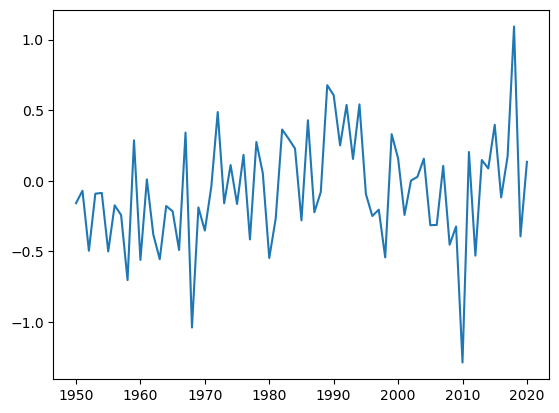

In [8]:
plt.plot(ds_index_g['year'], ds_index_g['nao'])

##### Since the NAO only has a positive and negative phase, I defined the nao values greater than or equal to 0.25 as 'positivenao' and the values less than or equal to -0.25 as 'negativenao.' I chose these values instead of zero because these intervals showed a very small p-value area, so I selected values other than zero that would help improve the significance test.

Positive NAO:  15
Negative NAO:  21
[array(15), array(21)]


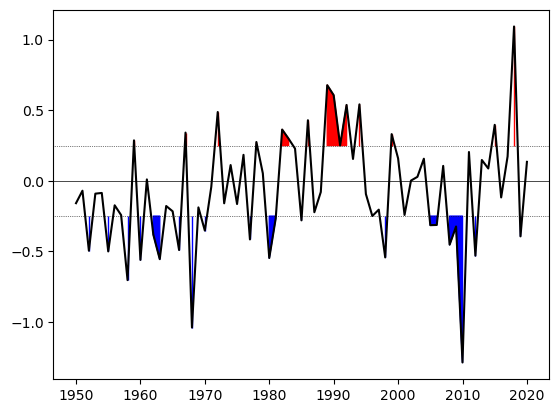

In [14]:
positivenao=ds_index_g['nao'].where(ds_index_g['nao']>=0.25)
negativenao=ds_index_g['nao'].where(ds_index_g['nao']<=-0.25)

print('Positive NAO: ',positivenao.count(dim='year').values)
print('Negative NAO: ',negativenao.count(dim='year').values)

counts=[positivenao.count(dim='year').values,  
        negativenao.count(dim='year').values]
print(counts)

plt.plot(ds_index_g['year'],ds_index_g['nao'],color='k')
plt.fill_between(ds_index_g['year'].values,positivenao,y2=0.25,color='red')
plt.fill_between(ds_index_g['year'].values,negativenao,y2=-0.25,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(0.25,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.25,color='black',linewidth=0.5,linestyle='dotted')

##### Opening my dataset

In [9]:
file='/home/jstiles4/clim680_dataset/ERA5_Reanalysis_Precip_dataset.grib'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:     (time: 252, latitude: 41, longitude: 53)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1989-12-31T18:00:00 ... 2010-11-30T18:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    tp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-11-16T12:35 GRIB to CDM+CF via cfgrib-0.9.1...

##### Multplying by 1000 so the precipitation values (tp) will show up in units of mm/day

In [36]:
ds = ds*1000

##### Grouping my dataset by year to match the time dimension with the climate index

In [39]:
dg = ds.tp.groupby('time.year').mean()

##### Here, I calculated the mean values for daily precipitation by year for the entire Northeast U.S. (da_climo) and subtracted these mean values from all of the values for daily precipitation by year to get the daily precipiation anomaly values (da_anoms). 

In [12]:
da_climo = dg.tp.mean()
da_anoms = dg.tp-da_climo
da_anoms

<xarray.DataArray 'tp' (year: 22, latitude: 41, longitude: 53)>
array([[[-1.0942705e+00, -1.0179765e+00, -9.1688704e-01, ...,
         -6.6209555e-02,  6.2696934e-03,  1.6934800e-01],
        [-1.1410005e+00, -1.0380037e+00, -9.3691421e-01, ...,
          4.1555643e-02,  7.9702616e-02, -2.4247885e-02],
        [-1.0465868e+00, -9.5026565e-01, -8.8350844e-01, ...,
          1.9795823e-01,  1.9795823e-01,  9.3054056e-02],
        ...,
        [ 1.1935942e+00,  6.6621232e-01,  9.4961405e-02, ...,
          2.0061247e+00,  2.1434538e+00,  2.2159331e+00],
        [ 6.7765641e-01,  4.0299821e-01,  1.2929368e-01, ...,
          2.3828261e+00,  2.4820082e+00,  2.5993102e+00],
        [ 3.8297105e-01,  3.8392472e-01,  3.4673142e-01, ...,
          2.6994460e+00,  2.7948134e+00,  3.0723326e+00]],

       [[-7.1788692e-01, -6.8085265e-01, -6.4699721e-01, ...,
          4.9820900e-02,  2.6853085e-02,  1.5408993e-02],
        [-7.6676273e-01, -7.3115897e-01, -6.9730353e-01, ...,
          1.7872810e-02, -7.3123693e-02, -1.6292810e-01],
        [-7.6207399e-01, -7.3076153e-01, -6.7107749e-01, ...,
          1.3899088e-02, -1.0554862e-01, -1.9575024e-01],
...
        [ 7.9511714e-01,  4.5974183e-01,  1.0513401e-01, ...,
          3.5653026e+00,  3.4549148e+00,  3.2819822e+00],
        [ 6.4666200e-01,  3.5483766e-01,  2.2402763e-02, ...,
          4.1121559e+00,  3.9156988e+00,  3.7481697e+00],
        [ 3.4641361e-01,  6.9530010e-02, -8.6712837e-03, ...,
          4.7604952e+00,  4.5683298e+00,  4.3755283e+00]],

       [[-9.8745894e-01, -9.5486069e-01, -8.7180424e-01, ...,
          2.9254532e-01,  2.2821569e-01,  1.5625668e-01],
        [-1.0845604e+00, -1.0183234e+00, -9.3457341e-01, ...,
          1.4689326e-01,  5.8288336e-02,  2.0074844e-04],
        [-1.1012063e+00, -1.0358362e+00, -9.7462773e-01, ...,
          2.2222042e-02, -6.0314178e-02, -1.1840153e-01],
        ...,
        [ 2.4035335e-01, -2.0259857e-02, -2.5243616e-01, ...,
          2.2111647e+00,  2.1102488e+00,  2.1496093e+00],
        [ 6.3316822e-02, -1.6417789e-01, -3.7606692e-01, ...,
          2.4449017e+00,  2.3611515e+00,  2.3862941e+00],
        [-2.8382063e-01, -4.9779058e-01, -5.2917504e-01, ...,
          2.7814620e+00,  2.6826265e+00,  2.6987522e+00]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
  * year       (year) int64 1989 1990 1991 1992 1993 ... 2007 2008 2009 2010

##### Each of the NAO phases needed to be sliced to have the same interval of years (1990-2010) as my dataset

In [16]:
positivenao_g = positivenao.sel(year=slice(dg['year'][0],dg['year'][-1]))
negativenao_g = negativenao.sel(year=slice(dg['year'][0],dg['year'][-1]))

##### Here, I matched the anomalies by year with the respective years in which the Positive NAO or Negative NAO occurred

In [17]:
positivenao_tp = da_anoms.sel(year=positivenao_g.dropna(dim='year')['year']).mean(dim='year')
negativenao_tp = da_anoms.sel(year=negativenao_g.dropna(dim='year')['year']).mean(dim='year')

comp_precip = [positivenao_tp, negativenao_tp]
comp_precip

[<xarray.DataArray 'tp' (latitude: 41, longitude: 53)>
 array([[-0.89744264, -0.85011655, -0.7714252 , ..., -0.13810594,
         -0.13197334, -0.10039612],
        [-0.96878284, -0.91629106, -0.8374141 , ..., -0.12862222,
         -0.13915236, -0.2053533 ],
        [-0.94226533, -0.8904093 , -0.8252549 , ..., -0.05622248,
         -0.09675363, -0.16311343],
        ...,
        [ 0.66876864,  0.22210474, -0.1214962 , ...,  1.9607855 ,
          2.0188935 ,  2.066405  ],
        [ 0.31029317, -0.02430089, -0.29604506, ...,  2.3719118 ,
          2.395608  ,  2.4468682 ],
        [-0.09309789, -0.30290624, -0.3104694 , ...,  2.8787632 ,
          2.883929  ,  2.9413748 ]], dtype=float32)
 Coordinates:
     number     int64 0
     step       timedelta64[ns] 12:00:00
     surface    float64 0.0
   * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
   * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0,
 <xarray.DataArray 'tp' (latitude: 41, lo

##### These are the plots for the average anomalies that occur during a Positive NAO year of Negative NAO year

/home/jstiles4/.conda/envs/clim_data3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


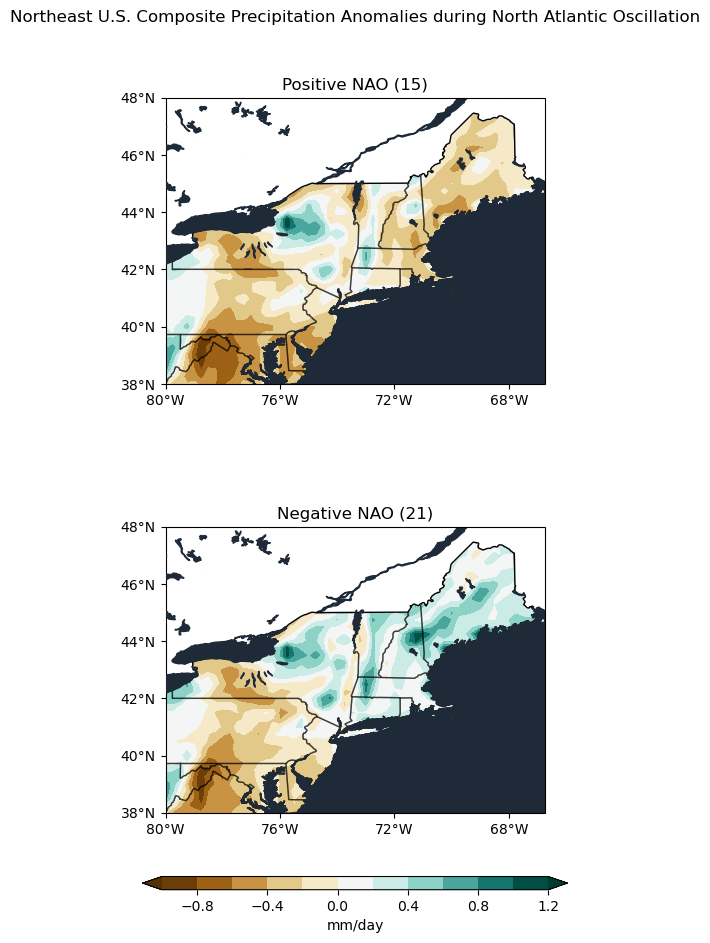

In [18]:
labels=['Positive NAO', 'Negative NAO']
clevs = np.arange(-1.0,1.4,0.2)

fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-74)},
                        figsize=(8.5,11))

axs = axs.flatten()

for i,tp in enumerate(comp_precip):

        data = comp_precip[i]

        data,lons = add_cyclic_point(data,coord=comp_precip[i]['longitude'])

        cs=axs[i].contourf(lons,comp_precip[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        axs[i].coastlines()
        axs[i].add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS, zorder=2, color='k')
        axs[i].add_feature(feature.LAKES, zorder=3, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
        axs[i].add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
        fname='/home/jstiles4/gadm41_CAN_1.shp'
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
        axs[i].add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Anomalies during North Atlantic Oscillation') ;

##### This is where I began the significance test for the composite, and I assigned two differences to the precipitation differences (diff_precip) array, those being Positive NAO Precipitation - Negative NAO Precipitation and Negative NAO Precipitation - Positive NAO Precipitation.

In [19]:
diff_precip=[positivenao_tp-negativenao_tp, negativenao_tp-positivenao_tp]

In [20]:
p = 0.05

##### For the t-test, I matched the anomaly values with the respective positive and negative NAO years

In [22]:
from scipy.stats import ttest_ind

positivenao_precip_vals = da_anoms.sel(year=positivenao_g.dropna(dim='year')['year'])
negativenao_precip_vals = da_anoms.sel(year=negativenao_g.dropna(dim='year')['year'])

In [23]:
tstat,pval = ttest_ind(positivenao_precip_vals, 
                negativenao_precip_vals, 
                equal_var = False)

##### This is the contour plot for the areas where the pvalue < p

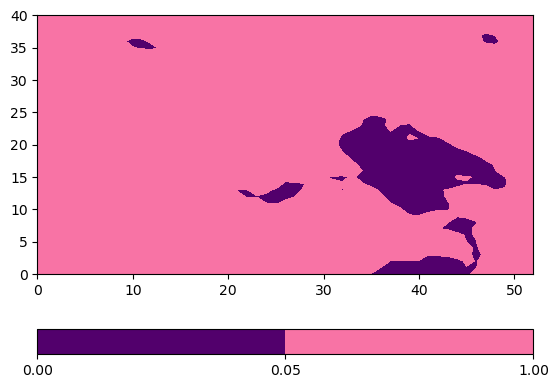

In [24]:
plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
plt.colorbar(orientation='horizontal') ;

In [25]:
mask_diff = diff_precip[0].where(pval <= p)
mask_diff

<xarray.DataArray 'tp' (latitude: 41, longitude: 53)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., -0.29457217,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0

##### These plots show the previously mentioned precipitation differences in diff_precip

Text(0.5, 0.98, 'Northeast U.S. Composite Precipitation Differences during North Atlantic Oscillation')

/home/jstiles4/.conda/envs/clim_data3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


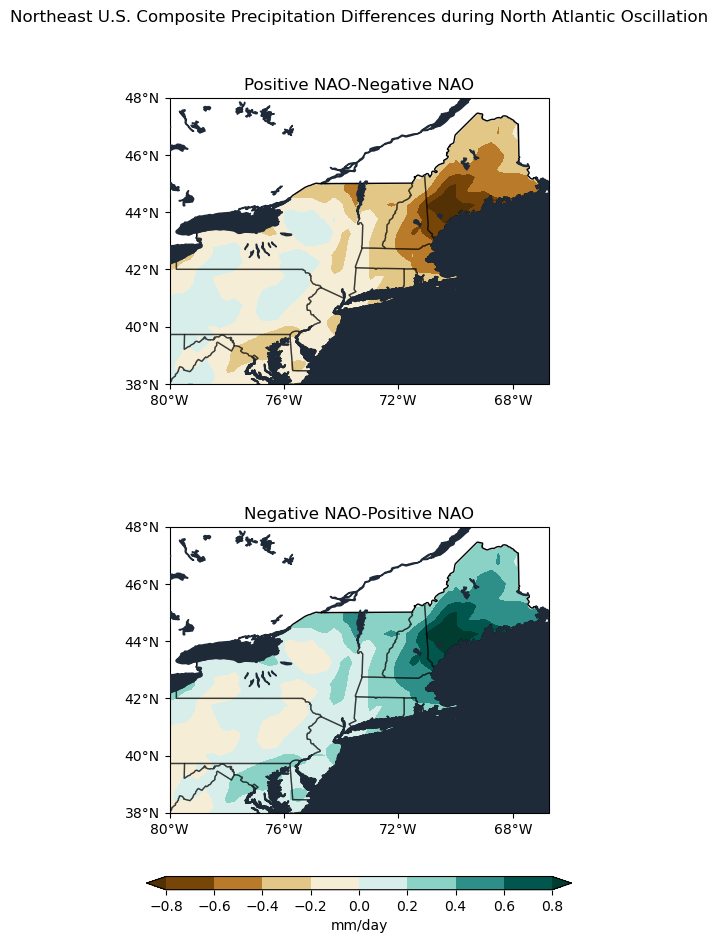

In [26]:
labels=['Positive NAO-Negative NAO','Negative NAO-Positive NAO']
clevs=np.arange(-0.8,0.9,0.2)

fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

axs = axs.flatten()

for i,enso in enumerate(diff_precip):

        data = diff_precip[i]

        data,lons = add_cyclic_point(data,coord=diff_precip[i]['longitude'])

        cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        axs[i].set_title(labels[i])
        
        axs[i].coastlines()
        axs[i].add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS, zorder=2, color='k')
        axs[i].add_feature(feature.LAKES, zorder=3, color='#1F2A38')
        axs[i].add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
        axs[i].add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
        fname='/home/jstiles4/gadm41_CAN_1.shp'
        shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
        axs[i].add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Differences during North Atlantic Oscillation')

##### Finally, I created a plot to show both the composite differences between Positive NAO-Negative NAO and the areas where the composite is significant. Based on this plot, the far northern parts of the Northeast U.S. near the Atlantic show strong significance, along with significance in northern New York and some close to Washington D.C.

Text(0.5, 0.98, 'Northeast U.S. Composite Precipitation Differences Positive NAO-Negative NAO')

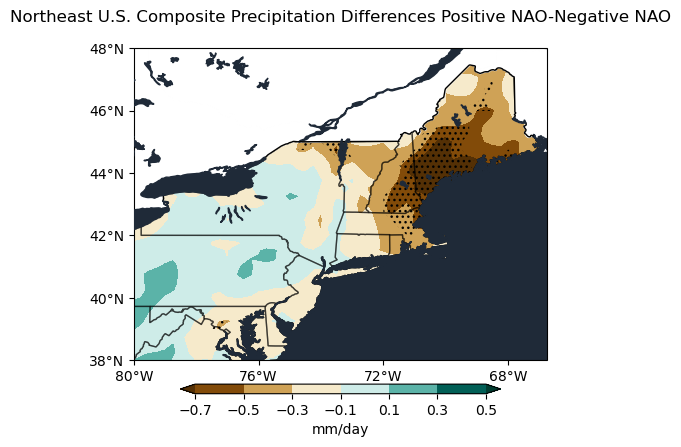

In [34]:
labels=['Positive NAO vs. Negative NAO']
clevs=np.arange(-0.7,0.6,0.2)
hatch_levs=[0]

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-74)})


data=diff_precip[0]

data,lons=add_cyclic_point(data,coord=diff_precip[0]['longitude'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['longitude'])

cs=axs.contourf(lons,diff_precip[0]['latitude'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

ss=axs.contourf(lons,diff_precip[0]['latitude'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['...','..'],extend='both',alpha=0.0)

axs.set_xticks([-80,-76,-72,-68], crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)

axs.set_yticks([38,40,42,44,46,48], crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)

axs.coastlines()
axs.add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
axs.add_feature(feature.BORDERS, zorder=2, color='k')
axs.add_feature(feature.LAKES, zorder=3, color='#1F2A38')
axs.add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
axs.add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
        
fname='/home/jstiles4/gadm41_CAN_1.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', color='white')
        
axs.add_feature(shape_feature)
        
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.02])

cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

plt.suptitle('Northeast U.S. Composite Precipitation Differences Positive NAO-Negative NAO')